**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# write your code here
import numpy as np
import pandas as pd
from copy import copy
from types import SimpleNamespace
import sympy as sm
from scipy import optimize
import matplotlib.pyplot as plt
import scipy.optimize as optimize


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor



The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.



**Answer 1:** 

To verify we; 
* define various functions and parameters in a SimpleNamespace called bl ('baseline')
* define both the given analytical solution, `L_opt_analytical()`, and `L_opt(G, bl)` which uses SciPy optimization (Nelder-Mead with bounds on L $\in (0,24))$
* run both the analytical solution and the SciPy optimizer function for $G \in \{1.0,2.0\}$ and find that $L^\star(\tilde w)≈ 15.3$ for both functions and instances of $G$

This is as expected, as it follows from the analytical solution that $^\star$ does not depend on G, but on dispensible income as well as the parameters of the model. 

In [2]:
bl = SimpleNamespace()
bl.alpha = 0.5
bl.kappa = 1.0
bl.nu = 1/(2*16**2)
bl.w = 1
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w
bl.sigma = 1.001
bl.rho = 1.001
bl.eps = 1


In [3]:
# Given list of G values
G_list = [1.0, 2.0]

# Calculate bl.w_tilde
bl.w_tilde = (1 - bl.tau) * bl.w

# Define value function
def V(L, G, bl):
    """
    Calculates the value function.

    Args:
        L (float): Labor input.
        G (float): G value.
        bl: An object with parameters.

    Returns:
        float: Value function output.
    """
    return np.log(((bl.kappa + (1 - bl.tau) * bl.w * L) ** bl.alpha) * G ** (1 - bl.alpha)) - bl.nu * ((L * L) / 2)

def L_opt_analytical(bl, G):
    """
    Calculates the analytical solution for optimal labor input.

    Args:
        bl: An object with parameters.
        G (list): List of G values.

    Returns:
        list: List of optimal labor inputs.
    """
    L_opt = []
    for k in G:
        L_opt.append((-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde))
    return L_opt

def L_opt(G, bl):
    """
    Calculates the numerical solution for optimal labor input.

    Args:
        G (list): List of G values.
        bl: An object with parameters.

    Returns:
        list: List of optimal labor inputs.
    """
    sol = []
    for k in G:
        obj = lambda L: -V(L, k, bl)
        x0 = 12
        sol.append(optimize.minimize(obj, x0, method='Nelder-Mead', bounds=((0, 24),)).x[0])
    return sol

# Calculate numerical solutions for optimal labor input
solutions = L_opt(G_list, bl)
solution = list(solutions)

# Calculate analytical solutions for optimal labor input
solution_analytical = L_opt_analytical(bl, G_list)

# Print the results
print(f"The estimated solutions for G=1 and G=2, respectively, are {solution}")
print(f"The analytical solutions for G=1 and G=2, respectively, are {solution_analytical}")


The estimated solutions for G=1 and G=2, respectively, are [15.301684570312506, 15.301684570312506]
The analytical solutions for G=1 and G=2, respectively, are [15.30165022719559, 15.30165022719559]


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.


**Answer 2:**

*Figure 1* shows how $L^\star(\tilde w) = L^\star((1-\tau)w)$ depends on $w$

To construct the figure we:
* initialize empty Numpy arrays for the solutions and create a grid of $w$'s
* we then iterate `L_opt(G,bl)` over all $w$'s, store the results in the empty arrays, and plot the figure

We notice that there is both a negative and positive effect on labour hours in the analytical solution given above. Ultimately though, we can see that the effect on labour hours from icreased wage is positive.

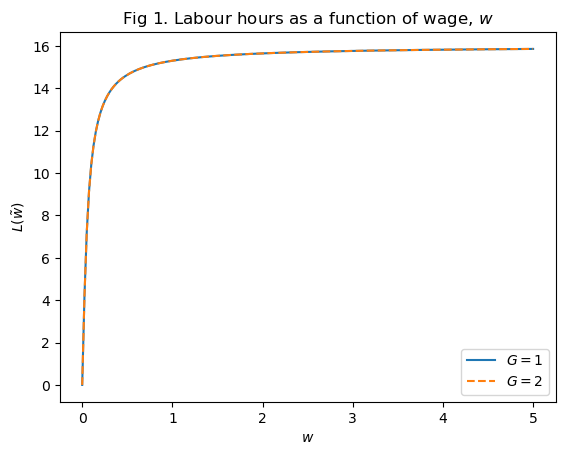

In [4]:
# Create grids
ws = np.linspace(0,5,200)
sols = np.empty((2,200))
sol_1 = np.empty(200)
sol_2 = np.empty(200)

# iterate and unnpack solution for each G
for i,w in enumerate(ws):
    bl.w = w
    sols = L_opt(G_list, bl)
    sols_list = list(sols)
    sol_1[i] = sols_list[0]
    sol_2[i] = sols_list[1]

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ws,sol_1, label = '$G=1$')
ax.plot(ws,sol_2,'--', label = '$G=2$')

ax.set_title(r"Fig 1. Labour hours as a function of wage, $w$")
ax.set_ylabel(r'$L(\tilde w)$')
ax.set_xlabel('$w$')
ax.legend()

# reset w and w_tilde
bl.w = 1.0
bl.w_tilde = (1-bl.tau)*bl.w






We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.



**Answer 3:**

*Figure 2* beneath shows the implied $L$, $G$ and worker utility for a grid of $\tau$'s. To construct, we:
* define the implied function for $G$ and and the analytical solution, not looping over $G$ as previously
* for each of $L$, $G$ and utility, $V$, we iterate over a grid of $\tau$'s and plot the three variables as a funciton of $\tau$ in *Figure 2* beneath
    * labour hours are strictly decreasing with $\tau$
    * government spending and worker utility are increasing and then decreasing, implying the existance of an optimal value, $\tau^\star$, that maximizes them both, respectively (id est the Laffer Curve)

When iterating, we use the analytical solution to find the number of labour hours, given $\tau$ since it does not depend on G in equilibrium. When then use that, $L$ to to calculate the corresponding G and lastly calculate the worker utility. 

/var/folders/vd/dwydg2bx2gz3j9x78jm_tx400000gn/T/ipykernel_7534/1686726482.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


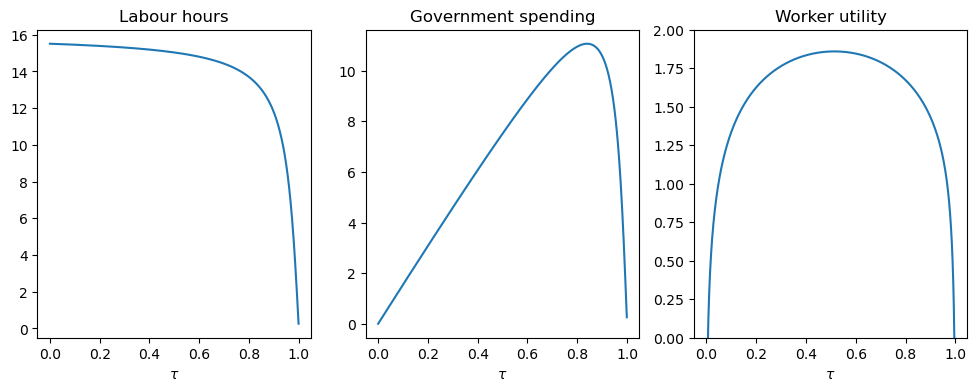

In [5]:
# Define G
def G_func(L, bl): return bl.tau*bl.w*L

# Define analytical solution with definition for G substituted
def L_analytical_func(bl): 
    return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)

def iterate_over_tau(bl, do_print = False):

    # Create grid of taus and empty arrays
    tau_grid = np.linspace(1e-8,1,1000)
    L_vec = np.empty(1000)
    G_vec = np.empty(1000)
    V_vec = np.empty(1000)

    # Iterate L, G and V over tau
    for i, tau in enumerate(tau_grid):
        bl.tau = tau 
        bl.w_tilde = (1-bl.tau)*bl.w

        L_vec[i] = L_analytical_func(bl)
        
        G_vec[i] = G_func(L_vec[i], bl)
        
        V_vec[i] = V(L_vec[i], G_vec[i], bl) 
      
        if do_print == True: 
            print(f'for tau = {tau}, L = {L_vec[i]}, G = {G_vec[i]} and V = {V_vec[i]}')

    return tau_grid, L_vec, G_vec, V_vec 

tau_grid, L_vec, G_vec, V_vec = iterate_over_tau(bl)    

# Plot figures
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
ax.plot(tau_grid, L_vec)
ax.set_title('Labour hours')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,2)
ax.plot(tau_grid, G_vec)
ax.set_title('Government spending')
ax.set_xlabel(r'$\tau$')

ax = fig.add_subplot(1,3,3)
ax.plot(tau_grid, V_vec)
ax.set_title('Worker utility')
ax.set_xlabel(r'$\tau$')
ax.set_ylim(0,2)

# reset tau and w_tilde
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w

    

 


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

**Answer 4:**

To find the optimal tax we use the approach of finding the maximizing argument.
* We run `iterate_over_tau()` and find the maximizing argument (ie. maximizing index)
* then we find $\tau$ for that index to be ~ $51.4\%$
* We plot the tax in *Figure 3* below

/var/folders/vd/dwydg2bx2gz3j9x78jm_tx400000gn/T/ipykernel_7534/1686726482.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return (-bl.kappa + np.sqrt(bl.kappa * bl.kappa + 4 * (bl.alpha / bl.nu) * bl.w_tilde * bl.w_tilde)) / (2 * bl.w_tilde)


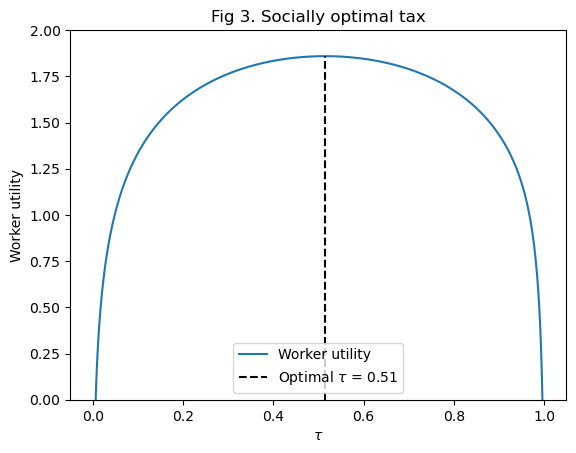

In [6]:
# Identify the maximum V and find the corresponding tau
tau_grid, L_vec, G_vec, V_vec = iterate_over_tau(bl)   
argmax_index = np.argmax((np.nan_to_num(V_vec)))
tau_opt  = tau_grid[argmax_index]

# Illustrate in figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_grid, V_vec, label = 'Worker utility')
ax.vlines(tau_opt,0,np.max(np.nan_to_num(V_vec)), linestyles='--', colors='black', label = fr'Optimal $\tau$ = {tau_opt:.2f}')
ax.set_ylim(0,2)
ax.set_ylabel('Worker utility')
ax.set_xlabel(r'$\tau$')
ax.set_title('Fig 3. Socially optimal tax')
ax.legend()

# reset tau and w_tilde
bl.tau = 0.3
bl.w_tilde = (1-bl.tau)*bl.w_tilde



A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Answer 5:**

To find the G that solves the equation, we define various functions, listed below:

* We define parameters and functions for calculating $C, G$ and the utility with `objective_function()`
* Function `solve_for_given_G()` solves for L for a given level of G and $\tau$ (here  $\tau^\star$) as the name states
* Function `find_opt_G()`iterates `solve_for_given_G()` over a grid og $G$ and finds the pair of $G$ and $L$ that satisfies the constraint
* For each of the two parameter values of $\sigma, \rho = \{1.001,1.5\}$ we find the pair of G and L given $\tau^\star$ and plot G as well as the deviation from the constraint in *Figure 4a* and *Figure 4b*

We notice that when $\rho, \sigma = 1.001$ the worker utility is approximately a Cobb-Douglas function


In [7]:
from scipy import interpolate

for rho, sigma = 1.001
G = [7.71099534] corresponds to L = 14.986962890625007  and minimizes the difference G - tau_opt*w*L = 0.01561922691337525
for rho, sigma = 1.5
G = [4.97509438] corresponds to L = 9.671630859374995  and minimizes the difference G - tau_opt*w*L = 0.006254623369768453


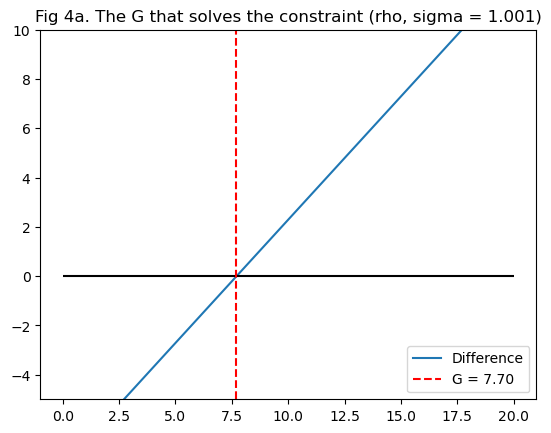

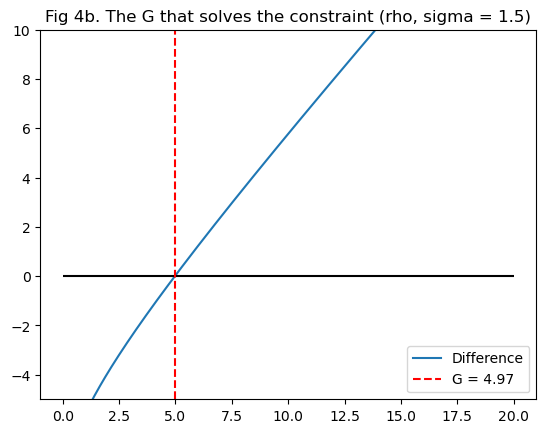

In [29]:
# define list of parameter values for rho and sigma 
par_list =[1.001,1.5]
letter_list = ['a','b']


#Define functions for private consumption and government spending
def calculate_C(bl, L):
    return bl.kappa + (1 - bl.tau) * bl.w * L

def calculate_G(bl, L, tau):
    # print(bl.tau,bl.w, L)
    return bl.tau*bl.w*L

# Define objective function
def objective_function(L, bl, G):
    C = calculate_C(bl, L)
    # G = calculate_G(bl,L)
    term1 = ((bl.alpha * C**((bl.sigma - 1) / bl.sigma) + (1 - bl.alpha) * G**((bl.sigma -1) / bl.sigma))**(bl.sigma / (bl.sigma-1)))**(1 - bl.rho) - 1
    term2 = bl.nu * L**(1 + bl.eps) / (1 + bl.eps)
    return -(term1 / (1 - bl.rho) - term2)

def solve_for_given_G(bl,G, tau):

    """
    Solves an optimization problem to find the value of 'L' for a given value of 'G' and 'tau'.

    Parameters:
        bl: An object or data structure representing some information.
        G: The given value of G.
        tau: The value of tau to be considered in the optimization problem. Default value is tau_opt.

    Returns:
        res: An object representing the result of the optimization.

    """
    
    # set tau and corresponding w_tilde
    bl.tau = tau
    bl.w = 1.0
    bl.w_tilde = (1-bl.tau)*bl.w

    # Define the bounds for L
    L_bounds = (1e-8, 24.0)

    # Set the initial guess for L
    x0 = 12

    # Define the optimization problem
    res = optimize.minimize(objective_function, x0, method = 'Nelder-Mead', args=(bl,G), bounds=([L_bounds]))    
   
    return res

def find_opt_G(bl,tau=tau_opt, do_print = False):

    """
        Finds optimal values of 'L' and calculates the difference between a range of 'G' values and tau*w*L.

        Parameters:
            bl: An object or data structure representing some information.
            tau: The value of tau to be considered in the optimization problem. Default value is tau_opt.
            do_print: A flag indicating whether to print additional information during the iteration. Default value is False.

        Returns:
            Gs: An array of 'G' values used in the iteration.
            Ls: An array of corresponding optimized values of 'L' for each 'G' value.
            diffs: An array of differences between 'G' and tau*w*L for each 'G' value.
            utility: The value of the objective function for the last iteration.

    """

    if do_print is True:
        print(bl)
        print(tau_opt)

    # initialize empty numpy arrays
    Gs = np.linspace(0e-16,20,500)
    Ls = np.empty(500)
    diffs = np.empty(500)
    utility = np.empty(500)
    
    # iterate over grid og G
    for i, g in enumerate(Gs):
        res = solve_for_given_G(bl,g,tau)
        Ls[i] = res.x
        diffs[i] = g - tau*bl.w*Ls[i]
        
        utility[i] = -res.fun

        if do_print is True: print(f'for G = {g} --> L = {Ls[i]} and diff = {diffs[i]}')

    # reset parameter space    
    bl.tau = 0.3
    bl.w_tilde = (1-bl.tau)*bl.w

    return Gs, Ls, diffs, utility, tau

# plot figures for each of the two parameter values

for i in [0,1]:
    bl.rho = par_list[i]                    # set parameter values
    bl.sigma = par_list[i]                  # set parameter values
    Gs, Ls, diffs, utility, tau = find_opt_G(bl) # run function optimzing over  
    print(fr'for rho, sigma = {bl.rho}')
    diffs_grid = interpolate.RegularGridInterpolator([Gs], diffs, bounds_error=False, fill_value=None)
    gx = lambda x: diffs_grid([x])[0]
    x_init = 0.2
    satisfaction_G = optimize.root(gx, x0=x_init).x
    print(f'G = {satisfaction_G} corresponds to L = {Ls[np.argmin(np.abs(diffs))]}'
      ,f' and minimizes the difference G - tau_opt*w*L = {np.min(np.abs(diffs))}')
    fig, ax = plt.subplots(1,1)
    ax.plot(Gs, diffs, label = 'Difference')
    ax.hlines(0, xmin=0, xmax=20, colors='black')
    ax.vlines(Gs[np.argmin(np.abs(diffs))], ymin=-5, ymax=16, linestyles="--", colors='red', label=f'G = {Gs[np.argmin(np.abs(diffs))]:.2f}')
    ax.set_ylim(-5,10)
    ax.legend(loc='lower right')
    ax.set_title(fr'Fig 4{letter_list[i]}. The G that solves the constraint (rho, sigma = {par_list[i]})')

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Answer 6:**

We now have to find the socially optimal $\tau$. For each level of $\tau$ a pair of G and L exists that satisfies the equation above. The $\tau$ that maximizes worker utility is the socially optimal level of taxation. 

We would expect results similar to those of the Cobb-douglas from earlier for  $\rho, \sigma = 1.001$ and less so for $\rho, \sigma = 1.5$

To find the optimal tax rate we:
* We define G as $G = \tau w L$ in the Valuefunction $\mathcal{V}$ we then optimize the value function over $\tau$ and $L$ using scipy. We also graphically examine the realtionship between $\tau$ and $\mathcal{V}$ for $G = \tau w L$.

In [30]:
# optimizer for fixed G
def sol_G_L(bl, x0):
    def objective(x):
        L, tau = x
        bl.tau = tau
        G = bl.w*bl.tau*L
        bl.w_tilde = (1-bl.tau)*bl.w
        return objective_function(L, bl, G)
    bnds = ((0, 24), (0, 1))
    x0 = x0
    res = optimize.minimize(objective, x0=x0, method='L-BFGS-B', bounds=bnds)
    return res

We find that the optimizer is sensitive to the starting values, and as such we optimize with a multistart approach.

In [31]:
Utilities = dict({1:[], 2:[]})
for i in [0,1]:
    bl.rho = par_list[i]
    bl.sigma = par_list[i]
    np.random.seed(1234)
    x01 = np.random.uniform(0, 24, 20)
    x02 = np.random.uniform(0,1, 20)
    Utilities[i+1] = list()
    from tqdm import tqdm
    for o in tqdm(x01):
        for x in x02:
            x0 = [o, x]
            top_dawg = sol_G_L(bl,x0)
            Utilities[i+1].append([-top_dawg.fun, top_dawg.x[0], top_dawg.x[1]])

100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


In [19]:
maximum_1 = Utilities[1][np.argmax(Utilities[1][0])]
maximum_2 = Utilities[2][np.argmax(Utilities[2][0])]

for i, x in [("par set 1", maximum_1),( "par set 2", maximum_2)]:
    print(f"for {i} the maximum utility is  {x[0]:.2f} and tau {x[2]:.2f}, with a labour supply of {x[1]:.2f}")

for par set 1 the maximum utility is  1.97 and tau 0.52, with a labour supply of 22.11
for par set 2 the maximum utility is  1.08 and tau 0.54, with a labour supply of 13.34


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [84]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [85]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [86]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [87]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [88]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [89]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [90]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [91]:
# write your code here